Device: cuda
ResNet18 model loaded successfully ✅
Prediction: PNEUMONIA, Confidence: 99.69%


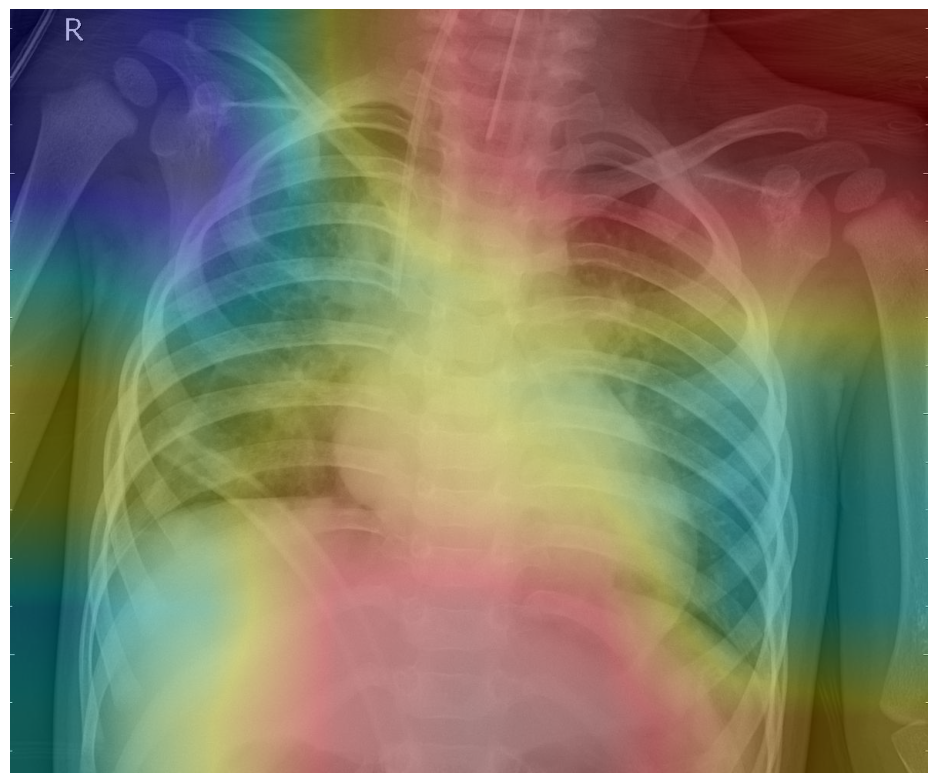

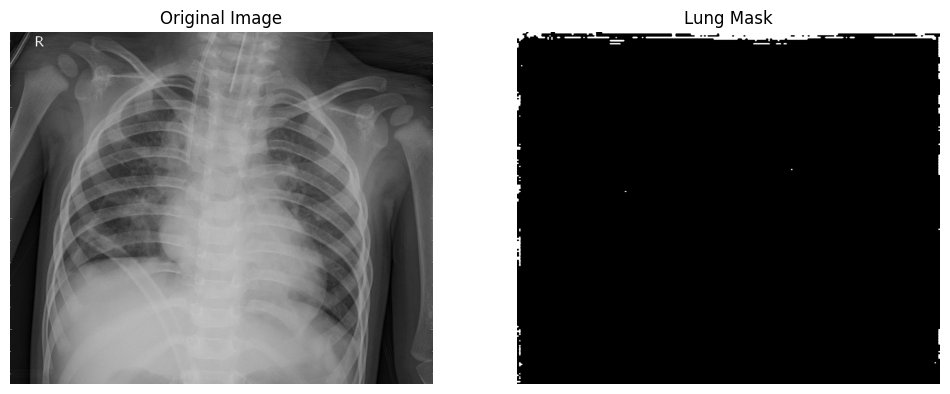

Inference complete!


In [28]:
# 3_inference.ipynb
# -----------------------------
# Milestone 5: Inference / Prediction
# -----------------------------

# 1️⃣ Import libraries
import torch
from torchvision import models, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp  # for pre-trained UNet

# -----------------------------
# 2️⃣ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# 3️⃣ Pre-trained U-Net for lung segmentation
# We will use this to get reliable lung masks
lung_model = smp.Unet(
    encoder_name="resnet34",       # Encoder architecture
    encoder_weights="imagenet",    # Use ImageNet pre-trained weights
    in_channels=3,                 # Input image channels (RGB)
    classes=1,                     # Output channels (binary mask)
    activation=None                # Raw logits output
)
lung_model = lung_model.to(device)
def segment_lungs_with_unet(image_path, model, device):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob_map = torch.sigmoid(output)
        mask = (prob_map > 0.5).cpu().numpy().squeeze()  # binary mask

    # ===== Resize mask to match original image size =====
    img_orig = cv2.imread(image_path)
    orig_height, orig_width = img_orig.shape[:2]
    mask_resized = cv2.resize(mask.astype(np.uint8), (orig_width, orig_height))
    # =====================================================

    # Display the mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    ax[1].imshow(mask_resized, cmap='gray')
    ax[1].set_title("Lung Mask")
    ax[1].axis('off')
    plt.show()

    return mask_resized


# Example usage:
# lung_mask = segment_lungs_with_unet(new_image_path, lung_model, device)

# -----------------------------
# 4️⃣ Load trained ResNet18 model for Pneumonia classification
model_path = "./src/models/pneumonia_resnet18.pt"  # adjust path if needed
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # 2 classes: NORMAL / PNEUMONIA
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print("ResNet18 model loaded successfully ✅")

# -----------------------------
# 5️⃣ Define transforms for inference
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # match training size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -----------------------------
# 6️⃣ Prediction function
def predict_xray(image_path):
    """
    Predict Pneumonia or NORMAL for a given X-ray image.

    Returns:
        prediction (str): "NORMAL" or "PNEUMONIA"
        confidence (float): probability %
    """
    image = Image.open(image_path).convert("RGB")
    input_tensor = test_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
    
    classes = ["NORMAL", "PNEUMONIA"]
    prediction = classes[preds.item()]
    confidence = probabilities[0][preds.item()].item() * 100
    return prediction, confidence

# -----------------------------
# 7️⃣ Grad-CAM heatmap
def generate_gradcam(model, input_tensor, target_class):
    """
    Generate Grad-CAM heatmap highlighting important regions.

    Args:
        model: classification model
        input_tensor: preprocessed image tensor
        target_class: class index (0 or 1)

    Returns:
        Normalized heatmap (0-1)
    """
    gradients = []
    activations = []

    # Hook functions to store activations/gradients
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    def forward_hook(module, input, output):
        activations.append(output)

    last_conv = model.layer4  # last conv layer in ResNet18
    last_conv.register_forward_hook(forward_hook)
    last_conv.register_backward_hook(backward_hook)

    # Forward and backward pass
    output = model(input_tensor)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    grad = gradients[0].cpu().detach().numpy()[0]
    act = activations[0].cpu().detach().numpy()[0]

    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))  # resize to input
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # normalize
    return cam

# -----------------------------
# 8️⃣ Overlay heatmap on original image
def overlay_heatmap(image_path, cam, alpha=0.3):
    """
    Overlay Grad-CAM heatmap on the original X-ray.
    alpha: heatmap opacity
    """
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (width, height))
    heatmap = np.float32(heatmap)/255
    img_rgb = np.float32(img)/255

    overlay = heatmap*alpha + img_rgb*(1-alpha)
    overlay = overlay / overlay.max()

    plt.figure(figsize=(width/100, height/100))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# -----------------------------
# 9️⃣ Test on a new image
new_image_path = "../data/chest_xray/test/PNEUMONIA/person173_bacteria_829.jpeg"
pred, conf = predict_xray(new_image_path)
print(f"Prediction: {pred}, Confidence: {conf:.2f}%")

if pred == "PNEUMONIA":
    # Grad-CAM heatmap
    input_tensor = test_transforms(Image.open(new_image_path).convert("RGB")).unsqueeze(0).to(device)
    cam = generate_gradcam(model, input_tensor, target_class=1)
    overlay_heatmap(new_image_path, cam)

    # Lung segmentation
    lung_mask = segment_lungs_with_unet(new_image_path, lung_model, device)

print("Inference complete!")
